In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import functools
import math
from itertools import combinations_with_replacement

import nibabel as nib
import numpy as np
from scipy import ndimage as ndi
from scipy import spatial, stats
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys, os
sys.path.append(os.path.dirname('../.'))
from scripts.utils import print_img, print_imgs

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import cv2

In [3]:
sample_name = "IXI100/IXI100-Guys-0747-MRA"
#sample_name = 'test'
path_to_nii_file = f"/home/msst/TEST/{sample_name}.nii.gz"

vol_file = nib.load(path_to_nii_file)
vol = np.array(vol_file.dataobj)
print(vol.shape)
print(vol.dtype)

(512, 512, 100)
float64


In [139]:
class GaussianBlur3D(nn.Module):
    def __init__(self, sigma):
        super(GaussianBlur3D, self).__init__()
        kernel_size = 1+6*int(sigma)
        gaussian_kernel = torch.from_numpy(cv2.getGaussianKernel(kernel_size, sigma)).squeeze().float()
        kernel3d = torch.einsum('i,j,k->ijk', gaussian_kernel, gaussian_kernel, gaussian_kernel)
        kernel3d /= kernel3d.sum()
        
        self.conv = nn.Conv3d(1, 1, kernel_size, stride=1, padding=kernel_size//2,
                              dilation=1, bias=False, padding_mode='replicate')
        self.conv.weight = torch.nn.Parameter(kernel3d.reshape(1, 1, *kernel3d.shape), requires_grad=False)
        
    def forward(self, vol):
        return self.conv(vol)


class HessianTorch(nn.Module):
    def __init__(self, sigma):
        super(HessianTorch, self).__init__()
        self.gauss = GaussianBlur3D(sigma=sigma)
        
    def forward(self, vol):
        axes = [2, 3, 4]
        gaussian_filtered = self.gauss(vol)
        
        gradient = torch.gradient(gaussian_filtered, dim=axes)
        H_elems = [torch.gradient(gradient[ax0-2], axis=ax1)[0]
              for ax0, ax1 in combinations_with_replacement(axes, 2)]
        return H_elems

In [137]:
vol = vol.astype(np.float32)
vol_t = torch.tensor(vol).unsqueeze(0).unsqueeze(0)
vol_cut = vol[100:400, 100:400]
vol_cut_t = torch.tensor(vol_cut).unsqueeze(0).unsqueeze(0)

In [138]:
Hess = HessianTorch(sigma=1)
H_t = Hess(vol_cut_t)
print(H_t[0][0, 0].shape)
H_t_out = torch.cat(H_t)
print(H_t_out.shape)

torch.Size([300, 300, 100])
torch.Size([6, 1, 300, 300, 100])


In [6]:
sigma = 1

In [7]:
t1 = time.time()
for i in range(10):
    a = scipy.ndimage.gaussian_filter(vol_cut, sigma=sigma)
print( time.time() - t1)

0.7526562213897705


In [8]:
t1 = time.time()
for i in range(10):
    a = GaussianBlur3D(sigma=sigma)(vol_cut_t)
print( time.time() - t1)

2.3969037532806396


In [9]:
blur_cuda = GaussianBlur3D(sigma=sigma).to('cuda')
vol_cut_t_cuda = vol_cut_t.to("cuda")

In [11]:
t1 = time.time()
for i in range(10):
    a = blur_cuda(vol_cut_t_cuda)
print( time.time() - t1)

0.00037288665771484375


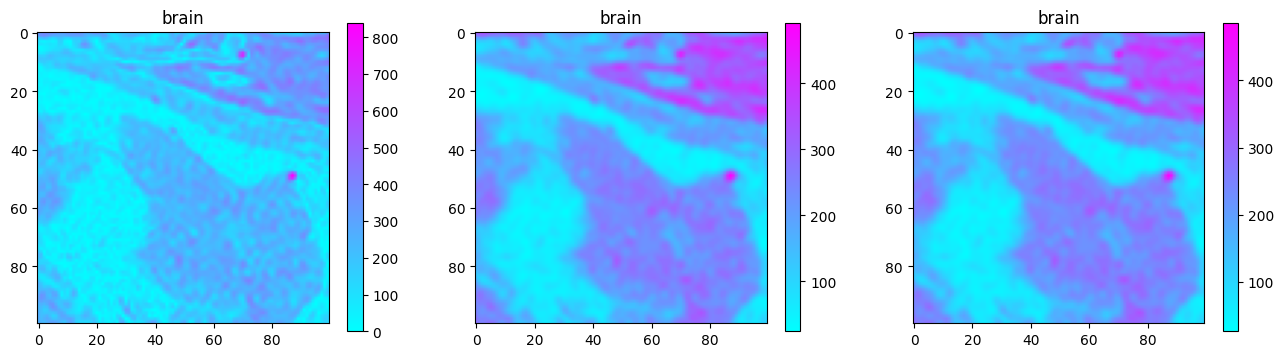

In [22]:
sigma = 1

my = GaussianBlur3D(sigma=sigma)(vol_cut_t)
sc_py = scipy.ndimage.gaussian_filter(vol_cut, sigma=sigma)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))    
idx = 0
print_img(vol_cut_t[0, 0][0:100, 100:200], ax[0], slice_=idx, title='brain', cmap='cool', bar=1)  
print_img(my[0, 0][0:100, 100:200], ax[1], slice_=idx, title='brain', cmap='cool', bar=1)  
print_img(sc_py[0:100, 100:200], ax[2], slice_=idx, title='brain', cmap='cool', bar=1)  


In [371]:
print((((test[0, 0][0:100, 100:200]-sc_py[0:100, 100:200])**2)**0.5).sum())
print((((my[0, 0][0:100, 100:200]-sc_py[0:100, 100:200])**2)**0.5).sum())

tensor(1822910.5767, dtype=torch.float64)
tensor(82248.0269, dtype=torch.float64)


In [29]:
vol_cut = vol[100:400, 100:400]
vol_cut_t = torch.tensor(vol_cut.astype(np.float32)).unsqueeze(0).unsqueeze(0)

blured2 = gaussian_blur_3d(vol_cut_t, kernel_size=3, sigma=1)
blured = scipy.ndimage.gaussian_filter(vol_cut, sigma=1)


print("delta:", np.sum(blured-blured2[0, 0].numpy()))
for idx in range(50, 60, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 2, figsize=(5, 4))    
    print_img(blured, ax[0], slice_=idx, title='brain', cmap='cool', bar=False)  
    print_img(blured2[0, 0], ax[1], slice_=idx, title='brain', cmap='cool', bar=False)  

tensor([[[0.0206, 0.0339, 0.0206],
         [0.0339, 0.0560, 0.0339],
         [0.0206, 0.0339, 0.0206]],

        [[0.0339, 0.0560, 0.0339],
         [0.0560, 0.0923, 0.0560],
         [0.0339, 0.0560, 0.0339]],

        [[0.0206, 0.0339, 0.0206],
         [0.0339, 0.0560, 0.0339],
         [0.0206, 0.0339, 0.0206]]])


TypeError: reshape(): argument 'shape' must be tuple of ints, but found element of type tuple at pos 2

In [133]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels,
                 kernel_size, stride, dilation,
                 padding_mode, act = nn.ReLU()):
        super().__init__()
        kernel_size_coef = (kernel_size-1)//2-1
        self.conv = nn.Conv3d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride,
                                 padding=dilation+kernel_size_coef, dilation=dilation,
                                 padding_mode=padding_mode)
        
        self.norm = torch.nn.InstanceNorm3d(out_channels, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        self.act = act
        
    def forward(self, x):
        return self.act(self.norm(self.conv(x)))


class MultuScaleDilationConvBlock(nn.Module):
    def __init__(self, in_channels=1, out_channels=8, stride=1, padding_mode='reflect'):
        super().__init__()
        
        self.Block1 = ConvBlock(in_channels, out_channels//4, kernel_size=1,
                                stride=stride, dilation=1, padding_mode=padding_mode)
        self.Block2 = ConvBlock(in_channels, out_channels//4, kernel_size=3,
                                stride=stride, dilation=1, padding_mode=padding_mode)
        self.Block3 = ConvBlock(in_channels, out_channels//4, kernel_size=3,
                                stride=stride, dilation=2, padding_mode=padding_mode)
        self.Block4 = ConvBlock(in_channels, out_channels//4, kernel_size=3,
                                stride=stride, dilation=4, padding_mode=padding_mode)


    def forward(self, x):
        x1 = self.Block1(x)
        x2 = self.Block2(x)
        x3 = self.Block3(x)
        x4 = self.Block4(x)
        return torch.cat((x1, x2, x3, x4), 1)

In [134]:
conv = MultuScaleDilationConvBlock(in_channels=1, out_channels=8, stride=1, padding_mode='zeros')

In [135]:
print(vol_cut_t.shape)
out = conv(vol_cut_t)
print(out.shape)

torch.Size([1, 1, 300, 300, 100])
torch.Size([1, 8, 300, 300, 100])


In [176]:
class HessNet(nn.Module):
    def __init__(self, start_scales, patch_size=(64, 64, 64)):
        super().__init__()
        
#         for scale in start_scales:
#             scales_dict.update({f"head_{i}" : torch.nn.parameter.Parameter(data=torch.tensor(scale, dtype=torch.float32))})
        
        self.scales = nn.parameter.Parameter(data=torch.tensor(start_scales, dtype=torch.float32))
        self.act = nn.Sigmoid()
        self.linear = nn.Sequential(
            nn.Linear(3, 10, bias=True),
            nn.ReLU(),
            #nn.Linear(10, 10, bias=False),
            #nn.PReLU(),
            nn.Linear(10, 1, bias=True)
        )
        self.flat = nn.Flatten(start_dim=1, end_dim=3)
        self.unflat = torch.nn.Unflatten(1, patch_size)
    
    def forward(self, x):
        hess_eigs = []
        for i in ra
        hes = get_batch_hess(x, 2).permute(0,2,3,4,1)
        x = hes.to("cuda")
        x = self.flat(x)
        x = self.linear(x)
        x = self.unflat(x)
        x = x.permute(0,4,1,2,3)
        x = self.act(x)
        return x
    

In [177]:
start_scales=np.array([0.1, 0.5, 1.0, 2.0])
model = HessNet(start_scales=start_scales)

In [178]:
model.scales

Parameter containing:
tensor([0.1000, 0.5000, 1.0000, 2.0000], requires_grad=True)